<div style="background-color: #a83d36; color: #FFFFFF; padding: 5px; text-align: center; border-radius: 15px; box-shadow: 0 4px 8px rgba(0, 0, 0, 0.5);">
  <h1 style="margin: 0; font-family: 'Helvetica Neue', Helvetica, Arial, sans-serif; font-weight: bold; font-size: 32px;">Understanding CNNs from Scratch</h1>
</div>


# Developing Custom Functions for CNN Implementation

In [18]:
#importing packages
import numpy as np
import matplotlib.pyplot as plt

<div style="background-color: #642420; color: #FFFFFF; padding: 5px; text-align: center; border-radius: 15px; box-shadow: 0 4px 8px rgba(0, 0, 0, 0.5);">
  <h2 style="margin: 0; font-family: 'Helvetica Neue', Helvetica, Arial, sans-serif; font-weight: bold; font-size: 24px;">Zero-Padding</h2>
</div>


Zero-padding adds zeros around the border of an image:



<div style="text-align:center;">
    <img src="images/padding.png" alt="gg" width="600"/>
</div>




In [19]:

def zero_pad(X, pad):
    """
    Pad with zeros all images of the dataset X. The padding is applied to the height and width of an image, 
    as illustrated in Figure 1.
    
    Argument:
    X -- python numpy array of shape (m, n_H, n_W, n_C) representing a batch of m images
    pad -- integer, amount of padding around each image on vertical and horizontal dimensions
    
    Returns:
    X_pad -- padded image of shape (m, n_H + 2 * pad, n_W + 2 * pad, n_C)
    """
    # Apply zero-padding to the input volume X.
    X_pad=np.pad(X,((0,0), (pad,pad),(pad,pad),(0,0)))
    
    return X_pad


<div style="background-color: #642420; color: #FFFFFF; padding: 5px; text-align: center; border-radius: 15px; box-shadow: 0 4px 8px rgba(0, 0, 0, 0.5);">
  <h2 style="margin: 0; font-family: 'Helvetica Neue', Helvetica, Arial, sans-serif; font-weight: bold; font-size: 24px;">Single Step of Convolution</h2>
</div>


<div style="text-align:center;">
<img src="images/Convolution_schematic.gif" style="width:500px;height:300px;">
</div>

In [34]:
def conv_single_step(a_slice_prev, W, b):
    """
    Apply one filter defined by parameters W on a single slice (a_slice_prev) of the output activation 
    of the previous layer.
    
    Arguments:
    a_slice_prev -- slice of input data of shape (f, f, n_C_prev)
    W -- Weight parameters contained in a window - matrix of shape (f, f, n_C_prev)
    b -- Bias parameters contained in a window - matrix of shape (1, 1, 1)
    
    Returns:
    Z -- a scalar value, the result of convolving the sliding window (W, b) on a slice x of the input data
    """


    # Element-wise product between a_slice_prev and W. Do not add the bias yet.
    s = a_slice_prev * W
    
    # Sum over all entries of the volume s.
    Z =np.sum(s)

    # Ensure b is a float for correct addition.
    b= np.float64(b)

    # Add bias b to Z. Cast b to a float() so that Z results in a scalar value.
    Z= Z+b


    return Z

 
<div style="background-color: #642420; color: #FFFFFF; padding: 5px; text-align: center; border-radius: 15px; box-shadow: 0 4px 8px rgba(0, 0, 0, 0.5);">
  <h2 style="margin: 0; font-family: 'Helvetica Neue', Helvetica, Arial, sans-serif; font-weight: bold; font-size: 24px;">CNN - Forward Pass</h2>
</div>

In the forward pass, you will take many filters and convolve them on the input. Each 'convolution' gives you a 2D matrix output. You will then stack these outputs to get a 3D volume:


    
The formulas relating the output shape of the convolution to the input shape are:
    
$$n_H = \Bigl\lfloor \frac{n_{H_{prev}} - f + 2 \times pad}{stride} \Bigr\rfloor +1$$
$$n_W = \Bigl\lfloor \frac{n_{W_{prev}} - f + 2 \times pad}{stride} \Bigr\rfloor +1$$
$$n_C = \text{number of filters used in the convolution}$$
    

In [39]:
def conv_forward(A_prev, W, b, hparameters):
    """
    Implements the forward propagation for a convolution function
    
    Arguments:
    A_prev -- output activations of the previous layer, 
        numpy array of shape (m, n_H_prev, n_W_prev, n_C_prev)
    W -- Weights, numpy array of shape (f, f, n_C_prev, n_C)
    b -- Biases, numpy array of shape (1, 1, 1, n_C)
    hparameters -- python dictionary containing "stride" and "pad"
        
    Returns:
    Z -- conv output, numpy array of shape (m, n_H, n_W, n_C)
    cache -- cache of values needed for the conv_backward() function
    """
    
    # Retrieve dimensions from A_prev's shape 
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    
    # Retrieve dimensions from W's shape
    (f, f, n_C_prev, n_C) = W.shape
    
    # Retrieve information from "hparameters" 
    stride = hparameters['stride']
    pad = hparameters['pad']
    
    # Compute the dimensions of the CONV output volume using the formula given above. 
    n_H = int((n_H_prev + 2*pad - f)/stride) + 1
    n_W = int((n_W_prev + 2*pad - f)/stride) + 1
    
    # Initialize the output volume Z with zeros.
    Z = np.zeros((m, n_H, n_W, n_C))
    
    # Create A_prev_pad by padding A_prev
    A_prev_pad = zero_pad(A_prev,pad)
    
    for i in range(m):               # loop over the batch of training examples
        a_prev_pad = A_prev_pad[i]               # Select ith training example's padded activation
        for h in range(n_H):           # loop over vertical axis of the output volume
            # Find the vertical start and end of the current "slice"
            vert_start = stride * h 
            vert_end = vert_start  + f
            
            for w in range(n_W):       # loop over horizontal axis of the output volume
                # Find the horizontal start and end of the current "slice"
                horiz_start = stride * w 
                horiz_end = horiz_start + f
                
                for c in range(n_C):   # loop over channels (= #filters) of the output volume
                                        
                    # Use the corners to define the (3D) slice of a_prev_pad (See Hint above the cell).
                    a_slice_prev = a_prev_pad[vert_start:vert_end,horiz_start:horiz_end,:]
                    
                    # Convolve the (3D) slice with the correct filter W and bias b, to get back one output neuron.
                    weights = W[:, :, :, c]
                    biases  = b[:, :, :, c]
                    Z[i, h, w, c] = conv_single_step(a_slice_prev, weights, biases)
    
    # Save information in "cache" for the backprop
    cache = (A_prev, W, b, hparameters)
    
    return Z, cache



<div style="background-color: #642420; color: #FFFFFF; padding: 5px; text-align: center; border-radius: 15px; box-shadow: 0 4px 8px rgba(0, 0, 0, 0.5);">
  <h2 style="margin: 0; font-family: 'Helvetica Neue', Helvetica, Arial, sans-serif; font-weight: bold; font-size: 24px;">Pooling Layer</h2>
</div>


- Max-pooling layer: slides an ($f, f$) window over the input and stores the max value of the window in the output.

- Average-pooling layer: slides an ($f, f$) window over the input and stores the average value of the window in the output.



<table>
<td>
<img src="images/max_pool1.png" style="width:500px;height:300px;">
<td>

<td>
<img src="images/a_pool.png" style="width:500px;height:300px;">
<td>
</table>

In [22]:
def pool_forward(A_prev, hparameters, mode = "max"):
    """
    Implements the forward pass of the pooling layer
    
    Arguments:
    A_prev -- Input data, numpy array of shape (m, n_H_prev, n_W_prev, n_C_prev)
    hparameters -- python dictionary containing "f" and "stride"
    mode -- the pooling mode you would like to use, defined as a string ("max" or "average")
    
    Returns:
    A -- output of the pool layer, a numpy array of shape (m, n_H, n_W, n_C)
    cache -- cache used in the backward pass of the pooling layer, contains the input and hparameters 
    """
    
    # Retrieve dimensions from the input shape
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    
    # Retrieve hyperparameters from "hparameters"
    f = hparameters["f"]
    stride = hparameters["stride"]
    
    # Define the dimensions of the output
    n_H = int(1 + (n_H_prev - f) / stride)
    n_W = int(1 + (n_W_prev - f) / stride)
    n_C = n_C_prev
    
    # Initialize output matrix A
    A = np.zeros((m, n_H, n_W, n_C))              
    
    for i in range(m):                         # loop over the training examples
        a_prev_slice = A_prev[i]
        for h in range(n_H):                     # loop on the vertical axis of the output volume
            # Find the vertical start and end of the current "slice" 
            vert_start = stride * h
            vert_end = vert_start  + f
            
            for w in range(n_W):                 # loop on the horizontal axis of the output volume
                # Find the vertical start and end of the current "slice" 
                horiz_start = stride * w
                horiz_end = horiz_start + f
                
                for c in range (n_C):            # loop over the channels of the output volume
                    
                    # Use the corners to define the current slice on the ith training example of A_prev, channel c. 
                    a_slice_prev = a_prev_slice[vert_start:vert_end,horiz_start:horiz_end,c]
                    
                    # Compute the pooling operation on the slice. 
                    # Use an if statement to differentiate the modes. 
                    # Use np.max and np.mean.
                    if mode == "max":
                        A[i, h, w, c] = np.max(a_slice_prev)
                    elif mode == "average":
                        A[i, h, w, c] = np.mean(a_slice_prev)
    
                    else:
                        print(mode+ "-type pooling layer NOT Defined")   
    
    # Store the input and hparameters in "cache" for pool_backward()
    cache = (A_prev, hparameters)
    
    # Making sure your output shape is correct
    assert(A.shape == (m, n_H, n_W, n_C))
    
    return A, cache


<div style="background-color: #642420; color: #FFFFFF; padding: 5px; text-align: center; border-radius: 15px; box-shadow: 0 4px 8px rgba(0, 0, 0, 0.5);">
  <h2 style="margin: 0; font-family: 'Helvetica Neue', Helvetica, Arial, sans-serif; font-weight: bold; font-size: 24px;"> Backpropagation in CNN</h2>
</div>

### Convolutional Layer - Backward Pass 


#### Computing dA:
This is the formula for computing $dA$ with respect to the cost for a certain filter $W_c$ and a given training example:

$$dA \mathrel{+}= \sum _{h=0} ^{n_H} \sum_{w=0} ^{n_W} W_c \times dZ_{hw} \tag{1}$$

#### Computing dW:
This is the formula for computing $dW_c$ ($dW_c$ is the derivative of one filter) with respect to the loss:

$$dW_c  \mathrel{+}= \sum _{h=0} ^{n_H} \sum_{w=0} ^ {n_W} a_{slice} \times dZ_{hw}  \tag{2}$$

#### Computing db:

This is the formula for computing $db$ with respect to the cost for a certain filter $W_c$:

$$db = \sum_h \sum_w dZ_{hw} \tag{3}$$

In [23]:
def conv_backward(dZ, cache):
    """
    Implement the backward propagation for a convolution function
    
    Arguments:
    dZ -- gradient of the cost with respect to the output of the conv layer (Z), numpy array of shape (m, n_H, n_W, n_C)
    cache -- cache of values needed for the conv_backward(), output of conv_forward()
    
    Returns:
    dA_prev -- gradient of the cost with respect to the input of the conv layer (A_prev),
               numpy array of shape (m, n_H_prev, n_W_prev, n_C_prev)
    dW -- gradient of the cost with respect to the weights of the conv layer (W)
          numpy array of shape (f, f, n_C_prev, n_C)
    db -- gradient of the cost with respect to the biases of the conv layer (b)
          numpy array of shape (1, 1, 1, n_C)
    """    
    
        
    # Retrieve information from "cache"
    (A_prev, W, b, hparameters) = cache
    
    # Retrieve dimensions from A_prev's shape
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    
    # Retrieve dimensions from W's shape
    (f, f, n_C_prev, n_C) = W.shape
    
    # Retrieve information from "hparameters"
    stride = hparameters['stride']
    pad = hparameters['pad']
    
    # Retrieve dimensions from dZ's shape
    (m, n_H, n_W, n_C) = dZ.shape
    
    # Initialize dA_prev, dW, db with the correct shapes
    dA_prev = np.zeros(A_prev.shape)            
    dW = np.zeros(W.shape)       
    db = np.zeros(b.shape)       
    
    # Pad A_prev and dA_prev
    A_prev_pad = zero_pad(A_prev, pad)
    dA_prev_pad = zero_pad(dA_prev, pad)
    
    for i in range(m):                       # loop over the training examples
        
        # select ith training example from A_prev_pad and dA_prev_pad
        a_prev_pad = A_prev_pad[i]
        da_prev_pad = dA_prev_pad[i]
        
        for h in range(n_H):                   # loop over vertical axis of the output volume
            for w in range(n_W):               # loop over horizontal axis of the output volume
                for c in range(n_C):           # loop over the channels of the output volume
                    
                    # Find the corners of the current "slice"
                    vert_start = stride * h 
                    vert_end = vert_start + f
                    horiz_start = stride * w
                    horiz_end = horiz_start + f

                    # Use the corners to define the slice from a_prev_pad
                    a_slice = a_prev_pad[vert_start:vert_end,horiz_start:horiz_end,:]

                    # Update gradients for the window and the filter's parameters using the code formulas given above
                    da_prev_pad[vert_start:vert_end, horiz_start:horiz_end, :] += W[:,:,:,c] * dZ[i, h, w, c]
                    dW[:,:,:,c] += a_slice * dZ[i, h, w, c]
                    db[:,:,:,c] += dZ[i, h, w, c]
                    
        # Set the ith training example's dA_prev to the unpadded da_prev_pad
        dA_prev[i, :, :, :] = da_prev_pad[pad:-pad, pad:-pad, :]
    
    # Making sure your output shape is correct
    assert(dA_prev.shape == (m, n_H_prev, n_W_prev, n_C_prev))
    
    return dA_prev, dW, db

### Max Pooling - Backward Pass

$$ X = \begin{bmatrix}
1 && 3 \\
4 && 2
\end{bmatrix} \quad \rightarrow  \quad M =\begin{bmatrix}
0 && 0 \\
1 && 0
\end{bmatrix}\tag{4}$$

In [24]:
def create_mask_from_window(x):
    """
    Creates a mask from an input matrix x, to identify the max entry of x.
    
    Arguments:
    x -- Array of shape (f, f)
    
    Returns:
    mask -- Array of the same shape as window, contains a True at the position corresponding to the max entry of x.
    """    
    
    mask = (x == np.max(x))
    
    return mask

### Average Pooling - Backward Pass

$$ dZ = 1 \quad \rightarrow  \quad dZ =\begin{bmatrix}
1/4 && 1/4 \\
1/4 && 1/4
\end{bmatrix}\tag{5}$$

In [25]:
def distribute_value(dz, shape):
    """
    Distributes the input value in the matrix of dimension shape
    
    Arguments:
    dz -- input scalar
    shape -- the shape (n_H, n_W) of the output matrix for which we want to distribute the value of dz
    
    Returns:
    a -- Array of size (n_H, n_W) for which we distributed the value of dz
    """    
    # Retrieve dimensions from shape 
    (n_H, n_W) = shape
    
    # Compute the value to distribute on the matrix 
    average = np.prod(shape)
    
    # Create a matrix where every entry is the "average" value 
    a = (dz/average)*np.ones(shape)
    
    return a

### Putting it Together: Pool Backward

In [26]:
def pool_backward(dA, cache, mode = "max"):
    """
    Implements the backward pass of the pooling layer
    
    Arguments:
    dA -- gradient of cost with respect to the output of the pooling layer, same shape as A
    cache -- cache output from the forward pass of the pooling layer, contains the layer's input and hparameters 
    mode -- the pooling mode you would like to use, defined as a string ("max" or "average")
    
    Returns:
    dA_prev -- gradient of cost with respect to the input of the pooling layer, same shape as A_prev
    """
    # Retrieve information from cache
    (A_prev, hparameters) = cache
    
    # Retrieve hyperparameters from "hparameters"
    stride = hparameters["stride"]
    f = hparameters["f"]
    
    # Retrieve dimensions from A_prev's shape and dA's shape
    m, n_H_prev, n_W_prev, n_C_prev = A_prev.shape
    m, n_H, n_W, n_C = dA.shape
    
    # Initialize dA_prev with zeros
    dA_prev = np.zeros(A_prev.shape)
    
    for i in range(m): # loop over the training examples
        
        # select training example from A_prev
        a_prev = A_prev[i,:,:,:]
        
        for h in range(n_H):                   # loop on the vertical axis
            for w in range(n_W):               # loop on the horizontal axis
                for c in range(n_C):           # loop over the channels (depth)
        
                    # Find the corners of the current "slice" 
                    vert_start  = h * stride
                    vert_end    = h * stride + f
                    horiz_start = w * stride
                    horiz_end   = w * stride + f
                    
                    # Compute the backward propagation in both modes.
                    if mode == "max":
                        
                        # Use the corners and "c" to define the current slice from a_prev
                        a_prev_slice = a_prev[ vert_start:vert_end, horiz_start:horiz_end, c ]
                        
                        # Create the mask from a_prev_slice
                        mask = create_mask_from_window( a_prev_slice )

                        # Set dA_prev to be dA_prev + (the mask multiplied by the correct entry of dA)
                        dA_prev[i, vert_start:vert_end, horiz_start:horiz_end, c] += mask * dA[i, h, w, c]
                        
                    elif mode == "average":
                        
                        # Get the value da from dA
                        da = dA[i, h, w, c]
                        
                        # Define the shape of the filter as fxf
                        shape = (f,f)

                        # Distribute it to get the correct slice of dA_prev. i.e. Add the distributed value of da.
                        dA_prev[i, vert_start: vert_end, horiz_start: horiz_end, c] += distribute_value(da, shape)
    
    # Making sure your output shape is correct
    assert(dA_prev.shape == A_prev.shape)
    
    return dA_prev

<div style="background-color: #642420; color: #FFFFFF; padding: 5px; text-align: center; border-radius: 15px; box-shadow: 0 4px 8px rgba(0, 0, 0, 0.5);">
  <h2 style="margin: 0; font-family: 'Helvetica Neue', Helvetica, Arial, sans-serif; font-weight: bold; font-size: 24px;"> Example Usage</h2>
</div>

## Implementing zero_pad

x.shape =
 (4, 3, 3, 2)
x_pad.shape =
 (4, 9, 9, 2)
x[1,1] =
 [[ 0.90085595 -0.68372786]
 [-0.12289023 -0.93576943]
 [-0.26788808  0.53035547]]
x_pad[1,1] =
 [[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]


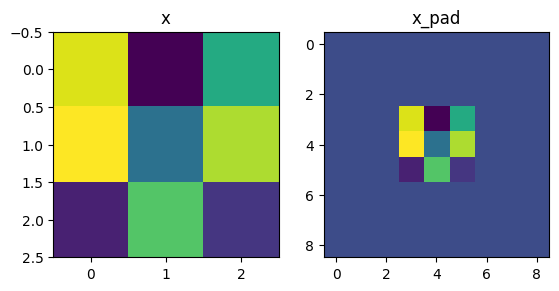

In [51]:
## zero-padding function to pad a 4D input tensor and visualize the padding.

np.random.seed(1)
x = np.random.randn(4, 3, 3, 2)
x_pad = zero_pad(x, 3)
print ("x.shape =\n", x.shape)
print ("x_pad.shape =\n", x_pad.shape)
print ("x[1,1] =\n", x[1, 1])
print ("x_pad[1,1] =\n", x_pad[1, 1])

fig, axarr = plt.subplots(1, 2)
axarr[0].set_title('x')
axarr[0].imshow(x[0, :, :, 0])
axarr[1].set_title('x_pad')
axarr[1].imshow(x_pad[0, :, :, 0])

## conv_single_step

In [37]:
# convolutional single step function to compute the output of a single convolutional neuron.

np.random.seed(1)
a_slice_prev = np.random.randn(4, 4, 3)
W = np.random.randn(4, 4, 3)
b = np.random.randn(1, 1, 1)

Z = conv_single_step(a_slice_prev, W, b)
print("Z =", Z)

assert (type(Z) == np.float64)

print("\033[92m All tests passed.")

Z = -6.999089450680221


## conv_forward

In [40]:
# convolutional forward function to perform forward propagation through a convolutional layer.

np.random.seed(1)
A_prev = np.random.randn(2, 5, 7, 4)
W = np.random.randn(3, 3, 4, 8)
b = np.random.randn(1, 1, 1, 8)
hparameters = {"pad" : 1,
               "stride": 2}

Z, cache_conv = conv_forward(A_prev, W, b, hparameters)
z_mean = np.mean(Z)
z_0_2_1 = Z[0, 2, 1]
cache_0_1_2_3 = cache_conv[0][1][2][3]
print("Z's mean =\n", z_mean)
print("Z[0,2,1] =\n", z_0_2_1)
print("cache_conv[0][1][2][3] =\n", cache_0_1_2_3)

print("\033[92m All tests passed.")


Z's mean =
 0.5511276474566768
Z[0,2,1] =
 [-2.17796037  8.07171329 -0.5772704   3.36286738  4.48113645 -2.89198428
 10.99288867  3.03171932]
cache_conv[0][1][2][3] =
 [-1.1191154   1.9560789  -0.3264995  -1.34267579]


## Pool_Forward

In [47]:
# pooling forward function to perform max and average pooling with different stride values.

## Case 1: stride of 1
print("CASE 1:\n")
print()
np.random.seed(1)
A_prev_case_1 = np.random.randn(2, 5, 5, 3)
hparameters_case_1 = {"stride" : 1, "f": 3}

A, cache = pool_forward(A_prev_case_1, hparameters_case_1, mode = "max")
print("mode = max")
print("A.shape = " + str(A.shape))
print("A[1, 1] =\n", A[1, 1])
print()

A, cache = pool_forward(A_prev_case_1, hparameters_case_1, mode = "average")
print("mode = average")
print("A.shape = " + str(A.shape))
print("A[1, 1] =\n", A[1, 1])
print()



## Case 2: stride of 2
print("\n\033[0mCASE 2:\n")
np.random.seed(1)
A_prev_case_2 = np.random.randn(2, 5, 5, 3)
hparameters_case_2 = {"stride" : 2, "f": 3}

A, cache = pool_forward(A_prev_case_2, hparameters_case_2, mode = "max")
print("mode = max")
print("A.shape = " + str(A.shape))
print("A[0] =\n", A[0])
print()

A, cache = pool_forward(A_prev_case_2, hparameters_case_2, mode = "average")
print("mode = average")
print("A.shape = " + str(A.shape))
print("A[1] =\n", A[1])
print()

print("\033[92m All tests passed.")

CASE 1:


mode = max
A.shape = (2, 3, 3, 3)
A[1, 1] =
 [[1.96710175 0.84616065 1.27375593]
 [1.96710175 0.84616065 1.23616403]
 [1.62765075 1.12141771 1.2245077 ]]

mode = average
A.shape = (2, 3, 3, 3)
A[1, 1] =
 [[ 0.44497696 -0.00261695 -0.31040307]
 [ 0.50811474 -0.23493734 -0.23961183]
 [ 0.11872677  0.17255229 -0.22112197]]


CASE 2:

mode = max
A.shape = (2, 2, 2, 3)
A[0] =
 [[[1.74481176 0.90159072 1.65980218]
  [1.74481176 1.6924546  1.65980218]]

 [[1.13162939 1.51981682 2.18557541]
  [1.13162939 1.6924546  2.18557541]]]

mode = average
A.shape = (2, 2, 2, 3)
A[1] =
 [[[-0.17313416  0.32377198 -0.34317572]
  [ 0.02030094  0.14141479 -0.01231585]]

 [[ 0.42944926  0.08446996 -0.27290905]
  [ 0.15077452  0.28911175  0.00123239]]]

 All tests passed.


## Conv_Backward

In [46]:
# Convolutional backward function to compute gradients for convolutional layer parameters.

## We'll run conv_forward to initialize the 'Z' and 'cache_conv",
## which we'll use to test the conv_backward function
np.random.seed(1)
A_prev = np.random.randn(10, 4, 4, 3)
W = np.random.randn(2, 2, 3, 8)
b = np.random.randn(1, 1, 1, 8)
hparameters = {"pad" : 2,
               "stride": 2}
Z, cache_conv = conv_forward(A_prev, W, b, hparameters)


# Test conv_backward
dA, dW, db = conv_backward(Z, cache_conv)

print("dA_mean =", np.mean(dA))
print("dW_mean =", np.mean(dW))
print("db_mean =", np.mean(db))

assert type(dA) == np.ndarray, "Output must be a np.ndarray"
assert type(dW) == np.ndarray, "Output must be a np.ndarray"
assert type(db) == np.ndarray, "Output must be a np.ndarray"
assert dA.shape == (10, 4, 4, 3), f"Wrong shape for dA  {dA.shape} != (10, 4, 4, 3)"
assert dW.shape == (2, 2, 3, 8), f"Wrong shape for dW {dW.shape} != (2, 2, 3, 8)"
assert db.shape == (1, 1, 1, 8), f"Wrong shape for db {db.shape} != (1, 1, 1, 8)"
assert np.isclose(np.mean(dA), 1.4524377), "Wrong values for dA"
assert np.isclose(np.mean(dW), 1.7269914), "Wrong values for dW"
assert np.isclose(np.mean(db), 7.8392325), "Wrong values for db"

print("\033[92m All tests passed.")

dA_mean = 1.4524377775388075
dW_mean = 1.7269914583139097
db_mean = 7.839232564616838
 All tests passed.


## Max Pooling - Backward Pass

In [48]:
# create_mask_from_window function to create a mask based on the maximum value in a window.

np.random.seed(1)
x = np.random.randn(2, 3)
mask = create_mask_from_window(x)
print('x = ', x)
print("mask = ", mask)

x = np.array([[-1, 2, 3],
              [2, -3, 2],
              [1, 5, -2]])

y = np.array([[False, False, False],
     [False, False, False],
     [False, True, False]])
mask = create_mask_from_window(x)

assert type(mask) == np.ndarray, "Output must be a np.ndarray"
assert mask.shape == x.shape, "Input and output shapes must match"
assert np.allclose(mask, y), "Wrong output. The True value must be at position (2, 1)"

print("\033[92m All tests passed.")

x =  [[ 1.62434536 -0.61175641 -0.52817175]
 [-1.07296862  0.86540763 -2.3015387 ]]
mask =  [[ True False False]
 [False False False]]
 All tests passed.


## Average Pooling - Backward Pass

In [49]:
# distribute_value function to distribute a value evenly across a given shape.

a = distribute_value(2, (2, 2))
print('distributed value =', a)


assert type(a) == np.ndarray, "Output must be a np.ndarray"
assert a.shape == (2, 2), f"Wrong shape {a.shape} != (2, 2)"
assert np.sum(a) == 2, "Values must sum to 2"

a = distribute_value(100, (10, 10))
assert type(a) == np.ndarray, "Output must be a np.ndarray"
assert a.shape == (10, 10), f"Wrong shape {a.shape} != (10, 10)"
assert np.sum(a) == 100, "Values must sum to 100"

print("\033[92m All tests passed.")

distributed value = [[0.5 0.5]
 [0.5 0.5]]
 All tests passed.


## Pool_Backward

In [50]:
# pool_backward function to compute gradients for the pooling layer in both max and average pooling modes.

np.random.seed(1)
A_prev = np.random.randn(5, 5, 3, 2)
hparameters = {"stride" : 1, "f": 2}
A, cache = pool_forward(A_prev, hparameters)
print(A.shape)
print(cache[0].shape)
dA = np.random.randn(5, 4, 2, 2)

dA_prev1 = pool_backward(dA, cache, mode = "max")
print("mode = max")
print('mean of dA = ', np.mean(dA))
print('dA_prev1[1,1] = ', dA_prev1[1, 1])  
print()
dA_prev2 = pool_backward(dA, cache, mode = "average")
print("mode = average")
print('mean of dA = ', np.mean(dA))
print('dA_prev2[1,1] = ', dA_prev2[1, 1]) 

assert type(dA_prev1) == np.ndarray, "Wrong type"
assert dA_prev1.shape == (5, 5, 3, 2), f"Wrong shape {dA_prev1.shape} != (5, 5, 3, 2)"
assert np.allclose(dA_prev1[1, 1], [[0, 0], 
                                    [ 5.05844394, -1.68282702],
                                    [ 0, 0]]), "Wrong values for mode max"
assert np.allclose(dA_prev2[1, 1], [[0.08485462,  0.2787552], 
                                    [1.26461098, -0.25749373], 
                                    [1.17975636, -0.53624893]]), "Wrong values for mode average"
print("\033[92m All tests passed.")

(5, 4, 2, 2)
(5, 5, 3, 2)
mode = max
mean of dA =  0.14571390272918056
dA_prev1[1,1] =  [[ 0.          0.        ]
 [ 5.05844394 -1.68282702]
 [ 0.          0.        ]]

mode = average
mean of dA =  0.14571390272918056
dA_prev2[1,1] =  [[ 0.08485462  0.2787552 ]
 [ 1.26461098 -0.25749373]
 [ 1.17975636 -0.53624893]]
 All tests passed.
